In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os
import IPython.display as display

print(tf.__version__)
print(keras.__version__)

2.0.0
2.2.4-tf


In [2]:
tf.test.is_gpu_available()

True

In [3]:
tf.executing_eagerly()

True

In [4]:
tfrecord_train = 'train.tfrecords'
tfrecord_test = 'test.tfrecords'
tfrecord_dir = 'tfrecords'

cur_dir = os.getcwd()
train_tfr_path = os.path.join(cur_dir, tfrecord_dir, tfrecord_train)
print(train_tfr_path)
test_tfr_path = os.path.join(cur_dir, tfrecord_dir, tfrecord_test)

C:\Users\beplu\Desktop\ForJupyter\blurryDetector\tfrecords\train.tfrecords


In [5]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

img_width = 250
img_height = 250

tf.random.set_seed(777)

n_class = 2

n_train = 21172

n_test = 5293

lr_decay_ratio = 0.1
lr_decay_epoch_num = 10

In [6]:
def _parsed_function(tfrecord_serialized):
    features={'image_raw': tf.io.FixedLenFeature([], tf.string),
             'label': tf.io.FixedLenFeature([], tf.int64),
             'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth': tf.io.FixedLenFeature([], tf.int64),}
    return tf.io.parse_single_example(tfrecord_serialized, features)

In [14]:
def decode_image_function(dataset):
    dataset['image_raw'] = tf.cast(tf.image.decode_image(dataset['image_raw']), tf.float32)/255.
    dataset['label'] = tf.cast(dataset['label'], tf.int32)
    return dataset

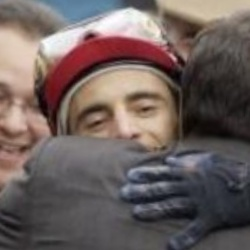

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>


ValueError: in converted code:

    <ipython-input-12-9341a639e25f>:2 decode_image_function  *
        dataset['image_raw'] = tf.cast(tf.image.decode_image(dataset['image_raw']), tf.float32)/255.
    C:\Users\beplu\Anaconda3\envs\virtualenv\lib\site-packages\tensorflow_core\python\ops\image_ops_impl.py:2317 decode_image
        is_jpeg(contents), _jpeg, check_png, name='cond_jpeg')
    C:\Users\beplu\Anaconda3\envs\virtualenv\lib\site-packages\tensorflow_core\python\util\deprecation.py:507 new_func
        return func(*args, **kwargs)
    C:\Users\beplu\Anaconda3\envs\virtualenv\lib\site-packages\tensorflow_core\python\ops\control_flow_ops.py:1174 cond
        return cond_v2.cond_v2(pred, true_fn, false_fn, name)
    C:\Users\beplu\Anaconda3\envs\virtualenv\lib\site-packages\tensorflow_core\python\ops\cond_v2.py:84 cond_v2
        op_return_value=pred)
    C:\Users\beplu\Anaconda3\envs\virtualenv\lib\site-packages\tensorflow_core\python\framework\func_graph.py:915 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    C:\Users\beplu\Anaconda3\envs\virtualenv\lib\site-packages\tensorflow_core\python\ops\image_ops_impl.py:2312 _jpeg
        gen_image_ops.decode_jpeg(contents, channels), dtype)
    C:\Users\beplu\Anaconda3\envs\virtualenv\lib\site-packages\tensorflow_core\python\ops\gen_image_ops.py:1211 decode_jpeg
        dct_method=dct_method, name=name)
    C:\Users\beplu\Anaconda3\envs\virtualenv\lib\site-packages\tensorflow_core\python\framework\op_def_library.py:793 _apply_op_helper
        op_def=op_def)
    C:\Users\beplu\Anaconda3\envs\virtualenv\lib\site-packages\tensorflow_core\python\framework\func_graph.py:548 create_op
        compute_device)
    C:\Users\beplu\Anaconda3\envs\virtualenv\lib\site-packages\tensorflow_core\python\framework\ops.py:3429 _create_op_internal
        op_def=op_def)
    C:\Users\beplu\Anaconda3\envs\virtualenv\lib\site-packages\tensorflow_core\python\framework\ops.py:1773 __init__
        control_input_ops)
    C:\Users\beplu\Anaconda3\envs\virtualenv\lib\site-packages\tensorflow_core\python\framework\ops.py:1613 _create_c_op
        raise ValueError(str(e))

    ValueError: Shape must be rank 0 but is rank 1 for 'DecodeJpeg' (op: 'DecodeJpeg') with input shapes: [?].


In [19]:
train_dataset = tf.data.TFRecordDataset(train_tfr_path)

train_dataset = train_dataset.map(_parsed_function)

for image_features in train_dataset:
    image_raw = image_features['image_raw'].numpy()
    display.display(display.Image(data=image_raw))
    break

#train_dataset = train_dataset.map(decode_image_function)
print(train_dataset)
#train_dataset = train_dataset.map(_parse_function, num_parallel_calls=8)
train_dataset = train_dataset.shuffle(buffer_size=n_train*2).prefetch(
    buffer_size=batch_size).batch(batch_size)

test_dataset = tf.data.TFRecordDataset(test_tfr_path)

test_dataset = test_dataset.map(_parsed_function)
test_dataset = train_dataset.map(decode_image_function)
#test_dataset = test_dataset.map(_parse_function, num_parallel_calls=8)
test_dataset = test_dataset.shuffle(buffer_size=n_train*2).prefetch(
    buffer_size=batch_size).batch(batch_size)

In [ ]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu, padding='SAME', input_shape=(250, 250, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation=tf.nn.relu))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(2))
    return model

    

In [ ]:
model = create_model()
model.summary()

In [ ]:
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
    return loss

In [ ]:
def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

In [ ]:
def evaluate(model, images, labels):
    logits = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [ ]:
optimizer = tf.keras.optimizers.Adam()

In [ ]:
for epoch in range(training_epochs):
    avg_loss = 0
    avg_train_acc = 0
    avg_test_acc = 0
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        print(tf.shape(images))
        images = tf.image.resize(images, (img_height, img_width))
        grads = grad(model, images, labels)
        optimizer.apply_gradients(zip(grads, model.variables))
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_test_acc / test_step
    
    for images, labels in test_dataset:
        images = tf.image.resize(images, (img_height, img_width)) 
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step
    
    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))

print('Learning Finished!')

In [ ]:
for i in range(3,5471):
    if 5471%i==0:
        print(i)